In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler   
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# make sure we're using the GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

torch.manual_seed(1)

Using cuda device


In [3]:
# need to choose ALL_DATA_Marc93.csv file from computer
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('ALL_DATA_Marc93.csv')
df.head()

Saving ALL_DATA_Marc93.csv to ALL_DATA_Marc93.csv


,Date,CPI,SPY,DGS6MO,UNRATE,G17
0,1-Mar-1993,143.3,0.017593,3.145652,7.0,65.0176
1,1-Apr-1993,143.8,-0.020986,3.062857,7.1,65.2041
2,1-May-1993,144.2,0.026970,3.165500,7.1,64.9433
3,1-Jun-1993,144.3,-0.003455,3.294545,7.0,65.0984
4,1-Jul-1993,144.5,0.002199,3.257619,6.9,65.2554


In [4]:
X = np.array(df[['SPY','DGS6MO','UNRATE','G17']])
y = np.array(df['CPI'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
class CPIDataset(Dataset):
    
    def __init__(self, X_data, y_data):
      if not torch.is_tensor(X) and not torch.is_tensor(y):
        X_data = MinMaxScaler().fit_transform(X_data)
        self.X_data = torch.from_numpy(X_data)
        self.y_data = torch.from_numpy(y_data)
        
    def __getitem__(self, i):
        return self.X_data[i], self.y_data[i]
        
    def __len__ (self):
        return len(self.X_data)

In [46]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)


In [110]:
EPOCHS = 150
BATCH_SIZE = 10
LEARNING_RATE = 0.001
NUM_FEATURES = len(X[0])

train_dataset = CPIDataset(X_train, y_train)
test_dataset = CPIDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

model = NeuralNetwork(NUM_FEATURES).to(device)
print(model)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [111]:
loss_stats = []

print("Begin training.")

for e in range(0, EPOCHS):
  curr_loss = 0
  model.train()
  for input, target in train_loader:
    input, target = input.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(input.float())
    train_loss = loss_function(output, target.float().unsqueeze(1))
    train_loss.backward()
    optimizer.step()
    curr_loss += train_loss.item()

  loss_stats.append(curr_loss/len(train_loader))
  print(f'Epoch {e+0:03}: | Train Loss: {curr_loss/len(train_loader):.5f}')

print('Training process has finished.')

Begin training.
Epoch 000: | Train Loss: 45355.38000
Epoch 001: | Train Loss: 45256.92672
Epoch 002: | Train Loss: 45081.31617
Epoch 003: | Train Loss: 44624.36188
Epoch 004: | Train Loss: 43469.33625
Epoch 005: | Train Loss: 40945.44703
Epoch 006: | Train Loss: 35990.08547
Epoch 007: | Train Loss: 28073.22609
Epoch 008: | Train Loss: 17747.49660
Epoch 009: | Train Loss: 7922.86072
Epoch 010: | Train Loss: 2717.86261
Epoch 011: | Train Loss: 1611.45566
Epoch 012: | Train Loss: 1503.27858
Epoch 013: | Train Loss: 1423.33671
Epoch 014: | Train Loss: 1338.23255
Epoch 015: | Train Loss: 1266.09353
Epoch 016: | Train Loss: 1204.67835
Epoch 017: | Train Loss: 1143.81553
Epoch 018: | Train Loss: 1089.65630
Epoch 019: | Train Loss: 1045.56294
Epoch 020: | Train Loss: 995.52991
Epoch 021: | Train Loss: 950.64171
Epoch 022: | Train Loss: 911.94126
Epoch 023: | Train Loss: 872.77324
Epoch 024: | Train Loss: 839.16508
Epoch 025: | Train Loss: 805.04469
Epoch 026: | Train Loss: 777.77043
Epoch 027:

Text(0.5, 1.0, 'Train Loss/Epoch')

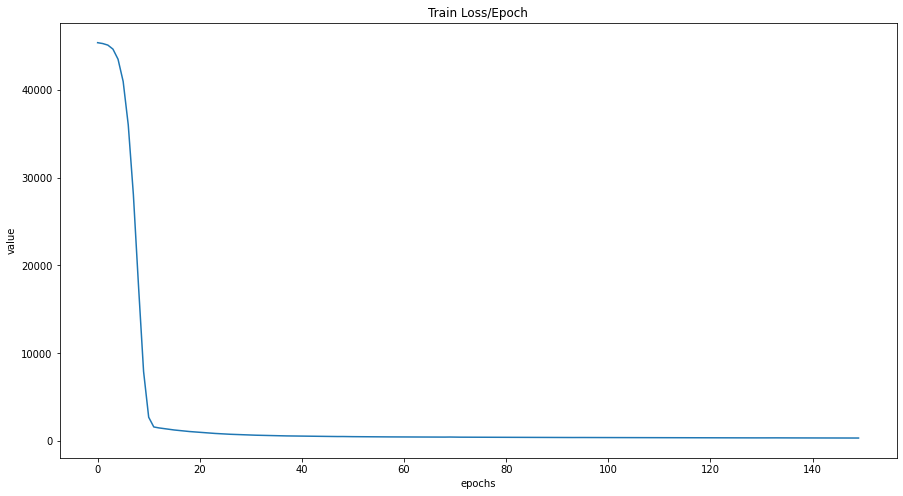

In [112]:
train_val_loss_df = pd.DataFrame(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value").set_title('Train Loss/Epoch')

In [113]:
y_pred = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.float()
        y_test_pred = model(X_batch)
        y_pred.append(y_test_pred.cpu().numpy())

y_pred = [a.squeeze().tolist() for a in y_pred]

In [114]:
mse = mean_squared_error(y_test, y_pred)
print("MSE =", mse)

MSE = 334.76240121430266


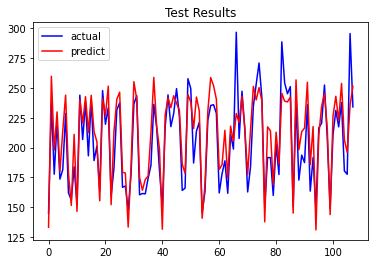

In [115]:
plt.plot(y_test, color = 'blue', label = 'actual') 
plt.plot(y_pred, color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()